In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [37]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [3]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
df.nunique()

lead_source                    5
industry                       7
number_of_courses_viewed      10
annual_income               1267
employment_status              4
location                       7
interaction_count             12
lead_score                   101
converted                      2
dtype: int64

In [7]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [8]:
for c in categorical:
    df[c] = df[c].fillna('NA')
for c in numerical:
    df[c] = df[c].fillna(0.0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1

In [12]:
for c in numerical:

    ans = roc_auc_score(y_true=y_train, y_score=df_train[c])
    if ans < 0.5:
        ans = roc_auc_score(y_true=y_train, y_score=-df_train[c])
    
    ans = round(ans, 3)

    print(f"Column {c} - AUC {ans}")

    

Column number_of_courses_viewed - AUC 0.764
Column annual_income - AUC 0.552
Column interaction_count - AUC 0.738
Column lead_score - AUC 0.614


In [13]:
# Answer is number_of_courses_viewed, with AUC = 0.764

## Question 2

In [14]:
# X training and validation using One-Hot encoding
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict_proba(X_val)[:,1]

In [15]:
# Calculating the AUC
auc_result = roc_auc_score(y_true=y_val, y_score=y_pred)
print(round(auc_result, 3))

0.817


In [16]:
# Answer is 0.817

## Question 3

In [24]:
thresholds = np.arange(0, 1, 0.01)
precision_results = []
recall_results = []

for t in thresholds:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)

    tp = (actual_positive & pred_positive).sum()
    tn = (actual_negative & pred_negative).sum()
    fp = (actual_negative & pred_positive).sum()
    fn = (actual_positive & pred_negative).sum()

    # Precision
    p = tp / (tp + fp)
    precision_results.append(p)

    # Recall
    r = tp / (tp + fn)
    recall_results.append(r)

    print(f"Precision = {p} | Recall = {r}")

Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | Recall = 1.0
Precision = 0.5836177474402731 | R

/tmp/ipykernel_2565/4231371142.py:19: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


Text(0.5, 0, 'Thresholds')

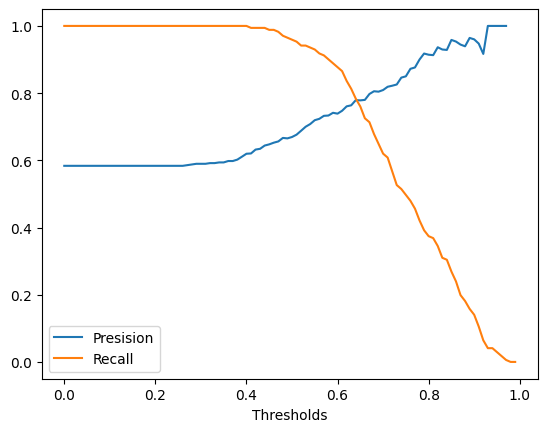

In [28]:
plt.plot(thresholds, precision_results, label='Presision')
plt.plot(thresholds, recall_results, label='Recall')
plt.legend()
plt.xlabel('Thresholds')

# The option that is closer to the answer is 0.745

## Question 4

In [31]:
# F1 score
f1_scores = []
for index, t in enumerate(thresholds):
    f1 = 2 * (precision_results[index] * recall_results[index]) / (precision_results[index] + recall_results[index])
    f1_scores.append(f1)

Text(0.5, 0, 'Thresholds')

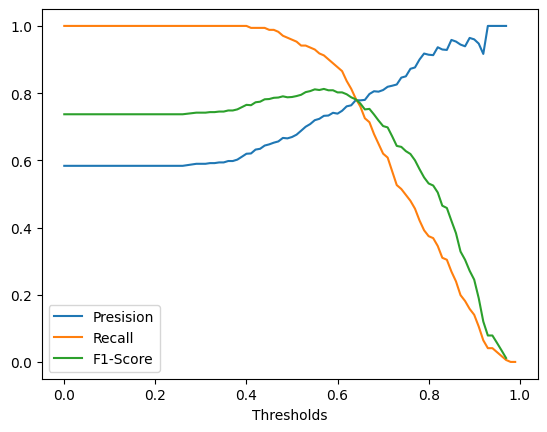

In [ ]:
plt.plot(thresholds, precision_results, label='Presision')
plt.plot(thresholds, recall_results, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.legend()
plt.xlabel('Thresholds')

# The option that is closer to the plot maximum F1 score is 0.54

## Question 5

In [ ]:
def train(df_train, y_train, C=1.0):
    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict) # One-hot encoding

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts) # One-hot encoding
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [40]:
n_folds = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.822 +- 0.036


In [ ]:
# answer is 0.036 (std - spread)
# The option that is closer to the result I got is 0.06

## Question 6

In [41]:
C = [0.000001, 0.001, 1]
n_folds = 5

for c in C:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

1e-06 0.560 +- 0.024


0it [00:00, ?it/s]

0.001 0.867 +- 0.029


0it [00:00, ?it/s]

1 0.822 +- 0.036


In [ ]:
# Answer is C = 0.001 obtains the best result, with 0.867 +- 0.029